In [22]:
# Importing modules
from numba import jit, vectorize, boolean, complex128
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
%matplotlib inline

# Naive implementation

In [23]:
# Creating grid
def make_grid(p_re, p_im):
    '''
    Creates a 2D array of complex numbers given a resolution parameters.
    :p_re: Resolution of the Real component of the grid
    :p_im: Resolution of the Imaginary component of the grid
    '''
    real = np.linspace(-2, 1, p_re)
    imag = np.linspace(-1.5, 1.5, p_im)
    grid_real, grid_imag = np.meshgrid(real, imag)
    return grid_real + grid_imag * 1j

# Check if the point is in Mandelbrot set
def isMandelbrot(c, maxIter, z=0, T=2):
    '''
    Checks if a complex number is in Mandelbrot set.
    :c: Comlex number
    :maxIter: Maximum iteration number to check for
    :z: (default:0) Starting point of calculation
    :T: (default:2) Threshold for determining if the point is in set
    '''
    for step in range(maxIter):
        z = z*z + c
        if abs(z) > T:
            return step
    return 0


In [49]:
# Compute Mandelbrot set
def Mandelbrot_set_naive(grid):
    '''
    Makes a Mandelbrot set.
    :grid: 2D array of complex numbers derived from make_grid() function
    '''
    result_grid = np.zeros(grid.shape)
    for i, row in enumerate(grid):
        for j, col in enumerate(grid):
            result_grid[i][j] = isMandelbrot(grid[i][j], 100) 
    return result_grid


### Visual confirmation that the code does what it should.

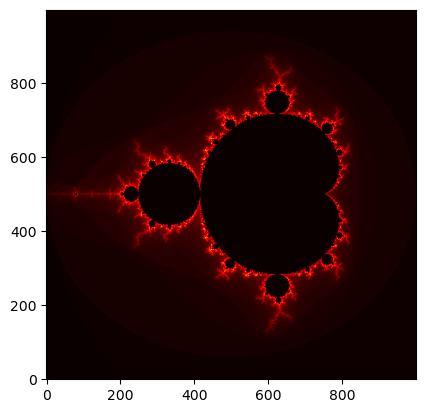

In [50]:

# Create Mandelbrot image helper function
def create_image(p_re, p_im, cmap='hot'):
    '''
    Make an image out of Mandelbrot set.
    :p_re: Resolution of the Real component of the grid
    :p_im: Resolution of the Imaginary component of the grid
    '''
    grid = make_grid(p_re, p_im)
    result_grid = Mandelbrot_set_naive(grid)
    plt.imshow(result_grid, cmap=cmap, origin='lower')

create_image(1000,1000)


In [51]:
grid = make_grid(5000, 5000)
%timeit Mandelbrot_set_naive(grid)

49.9 s ± 289 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**NAIVE:** 49.9 s ± 289 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

---

# Vectorized implementation

In [24]:
# Compute Mandelbrot set
def Mandelbrot_set_vectorized(grid):
    '''
    Makes a Mandelbrot set.
    :grid: 2D array of complex numbers derived from make_grid() function
    '''
    result_grid = np.zeros(grid.shape)
    vectorized_isMandelbrot = np.vectorize(isMandelbrot)
    result_grid = vectorized_isMandelbrot(grid, 100) 
    return result_grid

In [54]:
grid = make_grid(5000, 5000)
%timeit Mandelbrot_set_vectorized(grid)

28.9 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Vectorized:** 28.9 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

---

# Vectorized Multiprocessing implementation

In [25]:
M = mp.cpu_count()
pool = mp.Pool(M)

In [61]:
grid = make_grid(5000, 5000)
%timeit -r 7 -n 1 pool.map_async(Mandelbrot_set_vectorized, grid).get()

56.6 s ± 549 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Multiprocessing-Vectorized:** 56.6 s ± 549 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

---

# Vectorized Multiprocessing: Variable chunksize and processes implementation

In [26]:
from sys import getsizeof
grid = make_grid(5000, 5000)
print("Grid is roughly this size:", getsizeof(grid) / 1000000, "MB")

Grid is roughly this size: 400.000128 MB


In [73]:
M = mp.cpu_count()
M_list = [round(M * x/4) for x in range(1, 5)]
print(M_list)
all_thousands, all_hundreds, all_tens, all_ones = [], [], [], []
for M in M_list:
    pool = mp.Pool(M)
    
    chunksizes_t= np.arange(1, 6) * 1000
    thousands = [0] * 5
    for idx, csize in enumerate(chunksizes_t):
        thousands[idx] = %timeit -o -r 1 -n 1 pool.map_async(Mandelbrot_set_vectorized, grid, chunksize=csize).get()
    all_thousands.append(thousands)
    print("-") * 50

    chunksizes_h= np.arange(1, 6) * 100
    hundreds = [0] * 5
    for idx, csize in enumerate(chunksizes_h):
        hundreds[idx] = %timeit -o -r 1 -n 1 pool.map_async(Mandelbrot_set_vectorized, grid, chunksize=csize).get()
    all_hundreds.append(hundreds)
    print("-") * 50

    chunksizes_te= np.arange(1, 6) * 10
    tens = [0] * 5
    for idx, csize in enumerate(chunksizes_te):
        tens[idx] = %timeit -o -r 1 -n 1 pool.map_async(Mandelbrot_set_vectorized, grid, chunksize=csize).get()
    all_tens.append(tens)
    print("-")* 50

    chunksizes_o= np.arange(1, 6)
    ones = [0] * 5
    for idx, csize in enumerate(chunksizes_o):
        ones[idx] = %timeit -o -r 1 -n 1 pool.map_async(Mandelbrot_set_vectorized, grid, chunksize=csize).get()
    all_ones.append(ones)
    print("~") * 50
    

[5, 10, 15]
18.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
27.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
28.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
37 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
38.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.73 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
9.73 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
11.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
12.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
11 s ± 0 ns per loop (mean ± s

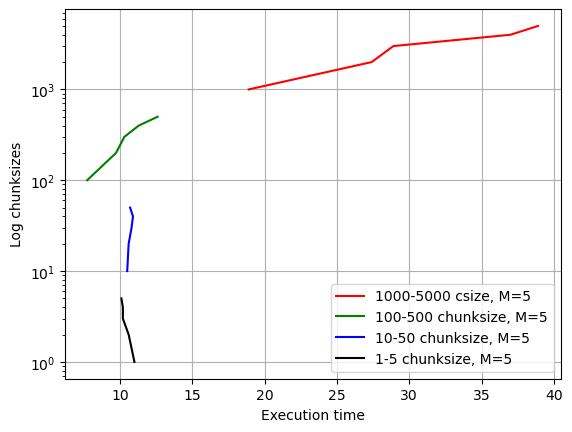

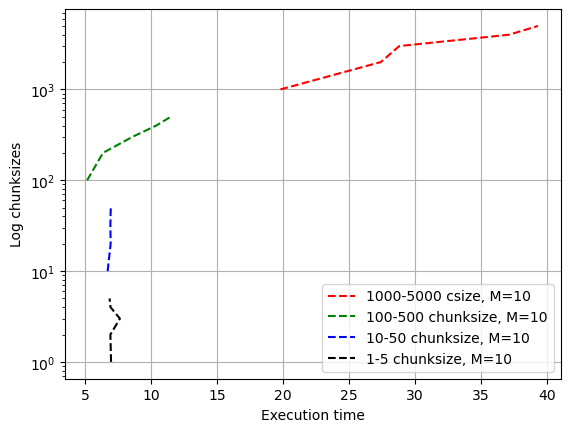

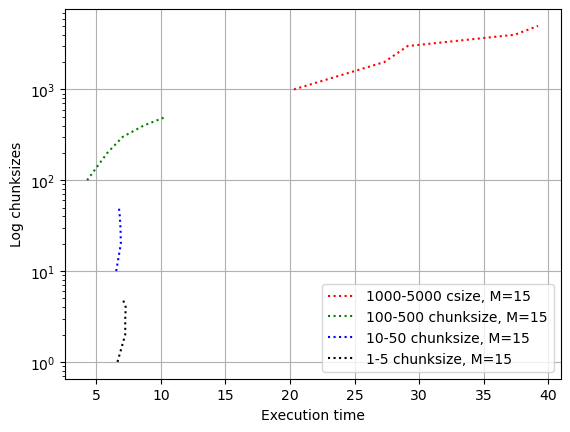

In [83]:
for thousands, hundreds, tens, ones, M, linestyle in zip(all_thousands, all_hundreds, all_tens, all_ones, M_list, ["-", "--", ":", "-."]):
    
    thousands = [float(str(x).split("s")[0]) for x in thousands]
    hundreds = [float(str(x).split("s")[0]) for x in hundreds]
    tens = [float(str(x).split("s")[0]) for x in tens]
    ones = [float(str(x).split("s")[0]) for x in ones]
    
    plt.plot(thousands, chunksizes_t, f"r{linestyle}", label=f"1000-5000 csize, M={M}")
    plt.plot(hundreds, chunksizes_h, f"g{linestyle}", label=f"100-500 chunksize, M={M}")
    plt.plot(tens, chunksizes_te, f"b{linestyle}", label=f"10-50 chunksize, M={M}")
    plt.plot(ones, chunksizes_o, f"k{linestyle}", label=f"1-5 chunksize, M={M}")
    plt.yscale("log")
    plt.ylabel("Log chunksizes")
    plt.xlabel("Execution time")
    plt.grid()

    plt.legend()
    plt.show()

### All-in-one

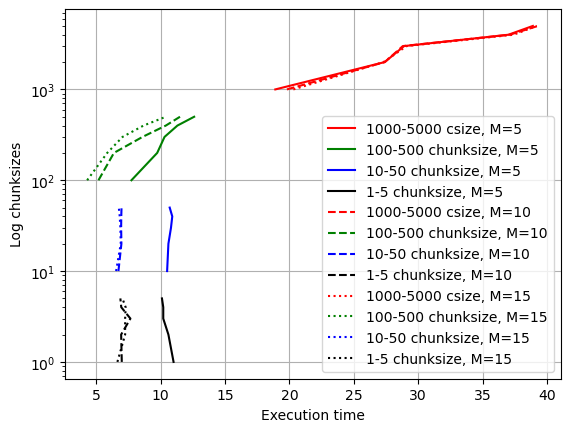

In [82]:
for thousands, hundreds, tens, ones, M, linestyle in zip(all_thousands, all_hundreds, all_tens, all_ones, M_list, ["-", "--", ":", "-."]):
    
    thousands = [float(str(x).split("s")[0]) for x in thousands]
    hundreds = [float(str(x).split("s")[0]) for x in hundreds]
    tens = [float(str(x).split("s")[0]) for x in tens]
    ones = [float(str(x).split("s")[0]) for x in ones]
    
    plt.plot(thousands, chunksizes_t, f"r{linestyle}", label=f"1000-5000 csize, M={M}")
    plt.plot(hundreds, chunksizes_h, f"g{linestyle}", label=f"100-500 chunksize, M={M}")
    plt.plot(tens, chunksizes_te, f"b{linestyle}", label=f"10-50 chunksize, M={M}")
    plt.plot(ones, chunksizes_o, f"k{linestyle}", label=f"1-5 chunksize, M={M}")
    plt.yscale("log")
    plt.ylabel("Log chunksizes")
    plt.xlabel("Execution time")
plt.grid()

plt.legend()
plt.show()

---

# Numba-naive implementation

In [ ]:
# Creating grid
def make_grid(p_re, p_im):
    '''
    Creates a 2D array of complex numbers given a resolution parameters.
    :p_re: Resolution of the Real component of the grid
    :p_im: Resolution of the Imaginary component of the grid
    '''
    real = np.linspace(-2, 1, p_re)
    imag = np.linspace(-1.5, 1.5, p_im)
    grid_real, grid_imag = np.meshgrid(real, imag)
    return grid_real + grid_imag * 1j


# Check if the point is in Mandelbrot set
@jit(nopython=True)
def isMandelbrot(c, maxIter, z=0, T=2):
    '''
    Checks if a complex number is in Mandelbrot set.
    :c: Comlex number
    :maxIter: Maximum iteration number to check for
    :z: (default:0) Starting point of calculation
    :T: (default:2) Threshold for determining if the point is in set
    '''
    for step in range(maxIter):
        z = z*z + c
        if abs(z) > T:
            return step
    return 0


In [ ]:
# Compute Mandelbrot set
@jit(nopython=True)
def Mandelbrot_set_naive(grid):
    '''
    Makes a Mandelbrot set.
    :grid: 2D array of complex numbers derived from make_grid() function
    '''
    result_grid = np.zeros(grid.shape)
    for i, row in enumerate(grid):
        for j, col in enumerate(grid):
            result_grid[i][j] = isMandelbrot(grid[i][j], 100) 
    return result_grid


In [ ]:
grid = make_grid(5000, 5000)
%timeit -r 7 -n 1 Mandelbrot_set_naive(grid)

2.53 s ± 94.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Numba-Naive:** 2.53 s ± 94.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

---

# Numba-naive optimized implementation

In [62]:
# Creating grid
def make_grid(p_re, p_im):
    '''
    Creates a 2D array of complex numbers given a resolution parameters.
    :p_re: Resolution of the Real component of the grid
    :p_im: Resolution of the Imaginary component of the grid
    '''
    real = np.linspace(-2, 1, p_re)
    imag = np.linspace(-1.5, 1.5, p_im)
    grid_real, grid_imag = np.meshgrid(real, imag)
    return grid_real + grid_imag * 1j


# Vectorized helper for in or out of threshold calculation
@vectorize([boolean(complex128)])
def notInSet(z):
    return (z.real*z.real + z.imag*z.imag) < 2.0


# Vectorized helper for z calculation
@vectorize([complex128(complex128, complex128)])
def zCalc(z,c):
    return z*z + c 


# Check if the point is in Mandelbrot set
@jit(nopython=True)
def isMandelbrot(c, maxIter, z=0):
    '''
    Checks if a complex number is in Mandelbrot set.
    :c: Comlex number
    :maxIter: Maximum iteration number to check for
    :z: (default:0) Starting point of calculation
    :T: (default:2) Threshold for determining if the point is in set
    '''
    for step in range(maxIter):
        z = zCalc(z,c)
        if notInSet(z):
            return step
    return 0


In [63]:
# Compute Mandelbrot set
@jit(nopython=True)
def Mandelbrot_set_naive(grid):
    '''
    Makes a Mandelbrot set.
    :grid: 2D array of complex numbers derived from make_grid() function
    '''
    result_grid = np.zeros(grid.shape, np.int8)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            result_grid[i][j] = isMandelbrot(grid[i][j], 100) 
    return result_grid

In [64]:
grid = make_grid(5000, 5000)
%timeit -r 7 -n 1 Mandelbrot_set_naive(grid)

1.67 s ± 45.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Numba-naive optimized:** 1.67 s ± 45.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

---

# Bonus Guvectorize attempt

In [65]:
# Original code belongs to Jean-François Puget. Below is my tweaked version.

import numpy as np
from numba import jit, vectorize, guvectorize, float64, complex64, int32, boolean


@vectorize([boolean(float64, float64)])
def notInSet(real, imag):
    return (real*real + imag*imag) > 2.0

@jit(int32(complex64, int32))
def mandelbrot(c,maxiter):
    nreal, real, imag = 0, 0, 0
    for n in range(maxiter):
        nreal = real*real - imag*imag + c.real
        imag = 2* real*imag + c.imag
        real = nreal; # Hopefully it is kept in the registere 
        if notInSet(real, imag):
            return n
    return 0

@guvectorize([(complex64[:], int32[:], int32[:])], '(n),()->(n)',target='parallel')
def mandelbrot_numpy(c, maxit, output):
    maxiter = maxit[0]
    for i in range(c.shape[0]):
        output[i] = mandelbrot(c[i],maxiter)
        
def mandelbrot_set2(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    n3 = mandelbrot_numpy(c,maxiter)
    return (r1,r2,n3.T) 

In [68]:
%timeit -r 7 -n 1 mandelbrot_set2(-2.0,1.0,-1.5,1.5,3000,3000,100)

47 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Guvectorize:** 47 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

### **Guvectorize** is x425 times faster than the **Naive** approach! 🚀

---

# _The fastest Mandelbrot set in the West_ (**GPU** multiprocessing) 🤠

In [69]:
from numba import cuda
from numba import *
import numpy as np
from pylab import imshow, show
from timeit import default_timer as timer


def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = x +  y*1j
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 2:
      return i

  return max_iters

mandel_gpu = cuda.jit(device=True)(mandel)




In [70]:
@cuda.jit
def mandel_kernel(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  startX, startY = cuda.grid(2)
  gridX = cuda.gridDim.x * cuda.blockDim.x;
  gridY = cuda.gridDim.y * cuda.blockDim.y;

  for x in range(startX, width, gridX):
    real = min_x + x * pixel_size_x
    for y in range(startY, height, gridY):
      imag = min_y + y * pixel_size_y 
      image[y, x] = mandel_gpu(real, imag, iters)

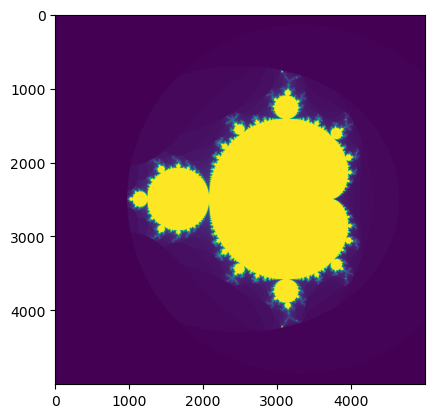

In [71]:


gimage = np.zeros((5000, 5000), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32,16)

d_image = cuda.to_device(gimage)
mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.5, 1.5, d_image, 100) 
d_image.copy_to_host()


imshow(d_image)
show()



In [78]:
%timeit -r 7 -n 1 mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.5, 1.5, d_image, 100) 

The slowest run took 10.08 times longer than the fastest. This could mean that an intermediate result is being cached.
63.1 µs ± 58.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


**RTX 4070 Ti OC GPU:** 63.1 µs ± 58.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

---

# Runtime visualization

```
p_re = p_im = 5000
maxIter = 100
T = 2
```

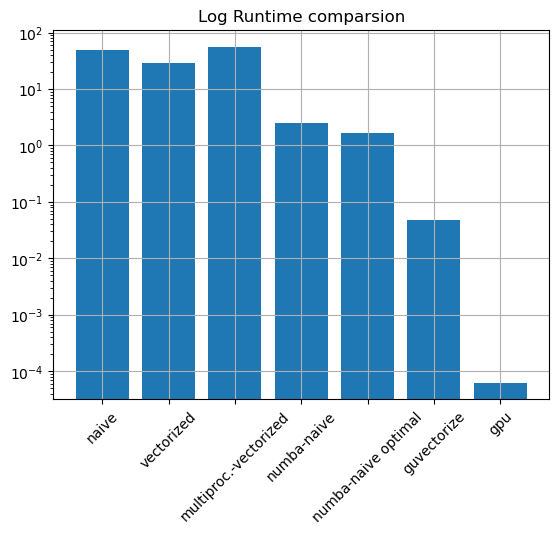

In [2]:
implementations = ["naive", "vectorized", "multiproc.-vectorized", "numba-naive", "numba-naive optimal", "guvectorize", "gpu"]
runtimes = [49.9, 28.9, 56.6, 2.53, 1.67, 0.047, 0.000063]

plt.bar(implementations, runtimes, log=True)
plt.xticks(rotation=45)
plt.title("Log Runtime comparsion")
plt.grid()
plt.show()

Random viz:

/tmp/ipykernel_7122/1886236221.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+implementations, rotation=90)
/tmp/ipykernel_7122/1886236221.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+implementations)


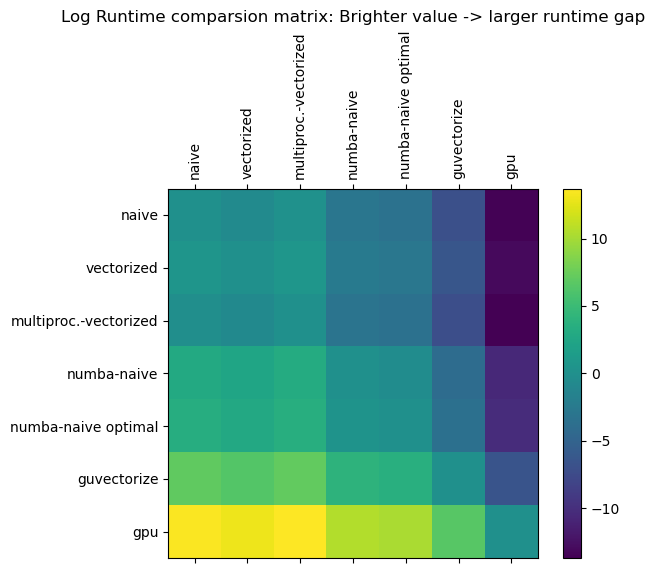

In [3]:
# %timeit -o will return time as object instead of printing it! -> seems usefull for creating graphs?
np.set_printoptions(precision=2)
runtimes_np = np.array(runtimes)
runtime_matrix = runtimes_np * (1/runtimes_np[:,np.newaxis])
runtime_matrix = np.log(runtime_matrix)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(runtime_matrix)
fig.colorbar(cax)
plt.title("Log Runtime comparsion matrix: Brighter value -> larger runtime gap")
ax.set_xticklabels(['']+implementations, rotation=90)
ax.set_yticklabels(['']+implementations)
plt.show()

In [105]:
# for idx, run, imp in enumerate(zip(runtimes[::-1], implementations[::-1])):
#     print(f"{imp} is faster than {implementations[::-1][idx+1]} for {runtimes[::-1][idx+1]/run} times.")

for idx, (run, imp) in enumerate(zip(runtimes, implementations)):
    if idx + 1 == len(implementations):
        break
    print(f"{"\033[95m"}{implementations[idx+1]} {"\033[0m"}is {"\033[93m"}{run/runtimes[idx+1]:.2f} {"\033[0m"}times faster than {"\033[96m"}{imp}")
    

vectorized is 1.73 times faster than naive
multiproc.-vectorized is 0.51 times faster than vectorized
numba-naive is 22.37 times faster than multiproc.-vectorized
numba-naive optimal is 1.51 times faster than numba-naive
guvectorize is 35.53 times faster than numba-naive optimal
gpu is 746.03 times faster than guvectorize


# Fun fact:

## GPU is **792063** times faster than the naive approach! 